In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, Softmax
from tensorflow.keras.utils import to_categorical
#from tensorflow import keras 
import numpy as np
#np.random.seed(66)

In [2]:
import tensorflow as tf

In [3]:
data1 = np.load('./roi_01-10_16x16x10.npy', allow_pickle=True)
data1_2 = np.load('./data_crop/positive/roi_0-5_20x20x16.npy', allow_pickle=True)
data2 = np.load('./roi_10-20_16x16x10.npy', allow_pickle=True)
 

In [36]:
data1 = np.concatenate((data1,data1_2))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [4]:
data = np.concatenate((data1,data2))
data.shape

(74, 16, 16, 10)

In [5]:
data_false = np.load('./negatives_16x16x10.npy', allow_pickle=True)
data_false.shape

(80, 16, 16, 10)

In [6]:
fulldata = np.concatenate((data,data_false))
fulldata.shape

(154, 16, 16, 10)

In [7]:
ones = [1 for i in range(data.shape[0])]
zeros = [0 for i in range(data_false.shape[0])]
y = ones + zeros
y = np.array(y)
y = y.reshape(-1,1)
y.shape

(154, 1)

In [8]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y)
onehotlabels = enc.transform(y).toarray()
onehotlabels.shape

/home/offsouza/miniconda3/envs/mri/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(154, 2)

In [9]:
fulldata_res = fulldata.reshape(154,16,16,10,1)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fulldata_res, onehotlabels, test_size=0.3,shuffle= True)

In [17]:
ishape = (16,16,10,1)

In [12]:
import  os
import  tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, optimizers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [13]:
strides=(1, 1, 1)
padding = 'valid'

In [18]:
class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
            print('#################: ',length)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            for z_start in range(0,f_size):
                X = int(x_start*win_size)
                Y = int(y_start*win_size)
                Z = int(z_start*win_size)
                #print('X:X+win_size: > ',X:X+win_size)
                print('X: > ',X)
                print('win_sixe: > ',win_size)
                print(inputs[:,X:X+win_size,Y:Y+win_size, Z:Z+win_size,:].shape)
                result = K.max(inputs[:,X:X+win_size,Y:Y+win_size, Z:Z+win_size,:],axis = (1,2,3))
                print(result)
                output.append(result)
      output = K.concatenate(output)
      return output

In [19]:
model = tf.keras.Sequential()

model.add(Conv3D(32, (7,7,5), strides=strides, padding=padding, input_shape=ishape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (5,5,3), strides=strides, padding=padding))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling3D(pool_size=(1,1,1)))
model.add(SppnetLayer([1,2,4]))
model.add(Dense(500))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
          
model.summary()

X: >  0
win_sixe: >  1
(None, 1, 1, 1, 64)
Tensor("sppnet_layer_1/Max:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_1:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_2:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_3:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_4:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_5:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_6:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_7:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_8:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  

In [20]:
# treinamento keras
# compilando o otimizador, função de perda e metricas
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
epochs = 1000

check = ModelCheckpoint(filepath='./weights_seq2keras21_09.hdf5', verbose=0, save_best_only=True, monitor='val_loss')
early = EarlyStopping(monitor='val_loss',patience=3)

# train
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_test, y_test),
         verbose=1, callbacks=[ check, early])



Epoch 1/1000
X: >  0
win_sixe: >  1
(None, 1, 1, 1, 64)
Tensor("sequential_1/sppnet_layer_1/Max:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_1:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_2:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_3:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_4:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_5:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_6:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_7:0", shape=(None, 64), dtype=float32)
X: >  0
win_s

X: >  0
win_sixe: >  1
(None, 1, 1, 1, 64)
Tensor("sequential_1/sppnet_layer_1/Max:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_1:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_2:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_3:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_4:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_5:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_6:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_7:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(No

1/2 [==============>...............] - ETA: 0s - loss: nan - accuracy: 0.5100X: >  0
win_sixe: >  1
(None, 1, 1, 1, 64)
Tensor("sequential_1/sppnet_layer_1/Max:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_1:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_2:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_3:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_4:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_5:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_6:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_

2/2 [==============================] - 1s 449ms/step - loss: nan - accuracy: 0.5047 - val_loss: nan - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 57ms/step - loss: nan - accuracy: 0.5047 - val_loss: nan - val_accuracy: 0.5532
Epoch 3/1000
2/2 [==============================] - 0s 56ms/step - loss: nan - accuracy: 0.5047 - val_loss: nan - val_accuracy: 0.5532


In [ ]:
# evaluate on test set
scores = model.evaluate(X_test, y_test, batch_size, verbose=1)
print("Final test loss and accuracy :", scores)

In [17]:
model.save('./tfmodels/mymodel71accseq21_09.hdf5')

In [21]:
model.save('./tfmodels/3dCNN_SPP_28_09')

X: >  0
win_sixe: >  1
(None, 1, 1, 1, 64)
Tensor("sequential_1/sppnet_layer_1/Max:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_1:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_2:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_3:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_4:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_5:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_6:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sequential_1/sppnet_layer_1/Max_7:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(No

X: >  0
win_sixe: >  1
(None, 1, 1, 1, 64)
Tensor("Max:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_1:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_2:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_3:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_4:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_5:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_6:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_7:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_8:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_9:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("Max_10:0", 

Tensor("sppnet_layer_1/Max_33:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_34:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_35:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_36:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_37:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_38:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_39:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_40:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_41:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sp

(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_37:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_38:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_39:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_40:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_41:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_42:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_43:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_44:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 0, 0, 64)
Tensor("sppnet_layer_1/Max_45:0", shape=(None, 64), dtype=float32)
X: >  0
win_sixe: >  0
(None, 0, 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./tfmodels/3dCNN_SPP_28_09/assets


In [19]:
model2 = tf.keras.models.load_model('tfmodels/mymodel78seq21_09')

In [20]:
# evaluate on test set
scores = model2.evaluate(X_test, y_test, batch_size, verbose=1)
print("Final test loss and accuracy :", scores)

1/1 [==============================] - 0s 850us/step - loss: 0.6909 - accuracy: 0.5319
Final test loss and accuracy : [0.6908751130104065, 0.5319148898124695]


In [21]:
for i in history.history:
    print(i)

loss
accuracy
val_loss
val_accuracy


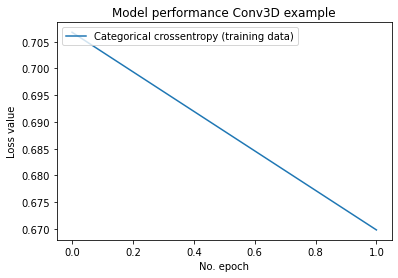

In [22]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
#plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
#plt.plot(history.history['accuracy'], label='Accuracy (training data)')
#plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

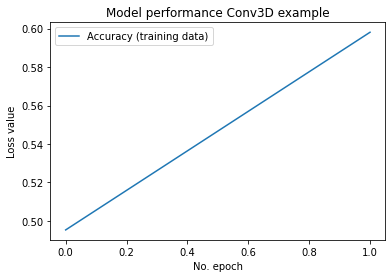

In [23]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
#plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
#plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
#plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()